In [1]:
import path
import libs.checker as checker
from control import *
from z3 import *
from scipy.signal import lti, step
import scipy.signal as sig
from matplotlib import pyplot as p

This example demonstrates that it is often a bad idea to drop significant dynamics to perform static checking. 

Specifically, considering transfer function:
$$
H(s) = \frac{-0.5s + 1}{s^2+3s+1}
$$
with the safety constraints of *y(t) >= 0*.

We might be tempted to drop $-0.5s$ term to analyze a standard 2nd order function.
$$
\hat{H}(s) = \frac{1}{s^2+3s+1}
$$


In [2]:
# Original Transfer function
Hs_num = [-0.5, 1]
Hs_den = [1, 1.9, 1]
Hs = lti(Hs_num, Hs_den)
tn, sn = step(Hs)

# Approximated transfer function
Hs_hat_num = [1]
Hs_hat_den = [1, 1.9, 1]
Hs_hat = lti(Hs_hat_num, Hs_hat_den)
tm, sm = step(Hs_hat)

In [3]:
# Chars calculation
wn_square = Hs_hat_den[-1]
two_zeta_wn = Hs_hat_den[-2]

omega_n = math.sqrt(wn_square)
zeta = two_zeta_wn/(2*omega_n)

print(f'zeta = {zeta}, omega_n = {omega_n}')


zeta = 0.95, omega_n = 1.0


In [4]:
# Setup
c = checker.Checker(zeta,omega_n)

y = c.factory.y
t = c.factory.t
c.amp = 1
r = c.amp
safety = y[t] >= 0

c.auto_pog(safety, c.factory.Lmin())

In [5]:
# Numerical Static Checking in Z3 SMT solver
c.result()

static checking result =  unsat


We might be happy that static checking tells us the design satisfy the requirement. However, it does not, as our approximation drop the significant dynamics of orginal transfer function.

Because the system exhibits what so called nonminimum-phase zero, i.e. a right hand zero in the complex plane at (0.5s - 1), which results a bizzare behavior that delays the system dynamics by first going to the wrong direction of the tracked reference. We can see this behavior by ploting the original system, and compared with the approximated transfer function: 

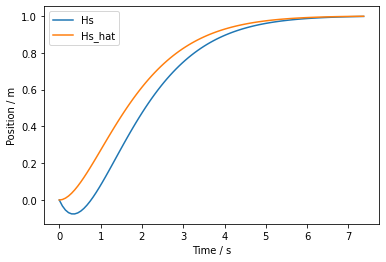

In [6]:
p.plot(tn, sn, label='Hs')
p.plot(tm, sm, label='Hs_hat')
p.xlabel('Time / s')
p.ylabel('Position / m')
p.legend()
p.show()

In summary, when static checking using our proposed approach, users should always make sure the approximation does not drop significant dynamics of the original system, by plotting or experimenting first. Because if not, the static checking result is less meaningful, and the user could try:
   * re-approximate
   * change the design or requirements
   * change the time-interval to ignore the nonminimum phase dynamics for certain systems, e.g. lifting up an aircraft, as they persist for a very short time

Otherwise, the user could review/fix the design further based on the checking result, and decide whether to perform more expensive design evaluation tasks next.